# MODEL TRAINING - testing the full approach - COGNITION
saving models in a different folder using pickle, saving them in the dataframe causes xgboost to crash

**DO NOT RUN AGAIN**

In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import uuid

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"/COGNITION_v2"
dreamspath=datapath+"/DREAMS"
masspath=datapath+"/MASS"


## experiment id
we'll use it to create a folder at the end of the script

In [2]:
experimentId=str(uuid.uuid4())

## define a fixed samplerate

In [3]:
samplerate=200

## load cognition

In [4]:
annotations, signalsMetadata = loadCOGNITIONSpindles_v2(cognipath)

In [5]:
annotations=annotations[annotations.type=='spindle'].reset_index(drop=True)
len(annotations)

14689

In [6]:
annotations.head()

,subjectId,channel,startTime,stopTime,duration,phase,type,samplerate,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,200,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,200,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,200,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,200,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,200,385728,385981


In [7]:
signalsMetadata

,filename,subjectId,channel,duration,samplerate,isOriginalSamplerate,database
0,COG001_F3.pkl,COG001,F3,39600.0,200,False,COGNITION_v2
1,COG001_C3.pkl,COG001,C3,39600.0,200,False,COGNITION_v2
2,COG001_F4.pkl,COG001,F4,39600.0,200,False,COGNITION_v2
3,COG001_C4.pkl,COG001,C4,39600.0,200,False,COGNITION_v2
4,COG002_F3.pkl,COG002,F3,39600.0,200,False,COGNITION_v2
...,...,...,...,...,...,...,...
71,COG018_C4.pkl,COG018,C4,39600.0,200,False,COGNITION_v2
72,COG019_F3.pkl,COG019,F3,41400.0,200,False,COGNITION_v2
73,COG019_C3.pkl,COG019,C3,41400.0,200,False,COGNITION_v2
74,COG019_F4.pkl,COG019,F4,41400.0,200,False,COGNITION_v2


## define a fixed feature selection to use

In [8]:
featureSelection=loadPickle("featureSelection26.pkl")
featureSelection

,window,characteristic,bandName,score
0,2,hjortActivity,beta2,69.0
1,1,hjortActivity,sigma,63.0
2,2,hjortActivity,beta1,42.0
3,2,hjortActivity,delta2,41.0
4,1.5,sigmaIndex,broadband,39.0
5,2,sigmaIndex,broadband,39.0
6,2,hjortActivity,theta,38.0
7,2,hjortMobility,beta1,37.0
8,2,hjortActivity,alpha,35.0
9,1,sigmaIndex,broadband,34.0


## load data split
LOOCV with 7 subjects

In [9]:
#by now we used fixed CV data splits instead
dataSplits=loadPickle("dataSplits_LOOCV.pkl")
dataSplits

,train,val,test
0,"[COG002, COG003, COG005, COG006, COG007, COG009]","[COG004, COG008]",COG001
1,"[COG003, COG004, COG006, COG007, COG008, COG009]","[COG001, COG005]",COG002
2,"[COG001, COG004, COG006, COG007, COG008, COG009]","[COG002, COG005]",COG003
3,"[COG001, COG003, COG005, COG006, COG007, COG008]","[COG002, COG009]",COG004
4,"[COG003, COG004, COG006, COG007, COG008, COG009]","[COG002, COG001]",COG005
5,"[COG002, COG003, COG004, COG005, COG008, COG009]","[COG001, COG007]",COG006
6,"[COG001, COG002, COG003, COG004, COG005, COG009]","[COG008, COG006]",COG007
7,"[COG001, COG002, COG004, COG005, COG007, COG009]","[COG006, COG003]",COG008
8,"[COG001, COG002, COG003, COG004, COG006, COG008]","[COG007, COG005]",COG009


## define annotation criteria

In [10]:
annotationCriteria=pd.DataFrame({
    'criteriumId':['0001'],
    'criteriumName':['E1'],
    'labelerIdList':[['0001']]
})

In [11]:
annotationCriteria

,criteriumId,criteriumName,labelerIdList
0,0001,E1,[0001]


In [12]:
experimentModels=pd.merge(annotationCriteria,dataSplits,how='cross')

In [13]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test
0,0001,E1,[0001],"[COG002, COG003, COG005, COG006, COG007, COG009]","[COG004, COG008]",COG001
1,0001,E1,[0001],"[COG003, COG004, COG006, COG007, COG008, COG009]","[COG001, COG005]",COG002
2,0001,E1,[0001],"[COG001, COG004, COG006, COG007, COG008, COG009]","[COG002, COG005]",COG003
3,0001,E1,[0001],"[COG001, COG003, COG005, COG006, COG007, COG008]","[COG002, COG009]",COG004
4,0001,E1,[0001],"[COG003, COG004, COG006, COG007, COG008, COG009]","[COG002, COG001]",COG005
5,0001,E1,[0001],"[COG002, COG003, COG004, COG005, COG008, COG009]","[COG001, COG007]",COG006
6,0001,E1,[0001],"[COG001, COG002, COG003, COG004, COG005, COG009]","[COG008, COG006]",COG007
7,0001,E1,[0001],"[COG001, COG002, COG004, COG005, COG007, COG009]","[COG006, COG003]",COG008
8,0001,E1,[0001],"[COG001, COG002, COG003, COG004, COG006, COG008]","[COG007, COG005]",COG009


In [14]:
annotations

,subjectId,channel,startTime,stopTime,duration,phase,type,samplerate,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,200,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,200,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,200,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,200,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,200,385728,385981
...,...,...,...,...,...,...,...,...,...,...
14684,COG009,C4,35328.677042,35329.338519,0.661477,3,spindle,200,7065735,7065868
14685,COG009,C4,35440.817120,35441.575876,0.758756,3,spindle,200,7088163,7088315
14686,COG009,C4,35521.498055,35522.373535,0.875480,3,spindle,200,7104300,7104475
14687,COG009,C4,39504.552529,39505.077815,0.525286,3,spindle,200,7900911,7901016


In [15]:
def loadFeature_v2(window,subject,channel,characteristic,bandName,samplerate,featurespath):
    filename=str(window)+'_'+subject+'_'+channel+'_'+characteristic+'_'+bandName+'.fd'
    filepath=featurespath+'/'+str(samplerate)+'fs/'+str(window)+'win/'+subject+'/'+channel+'/'+filename
    vector=loadPickle(filepath)
    return vector

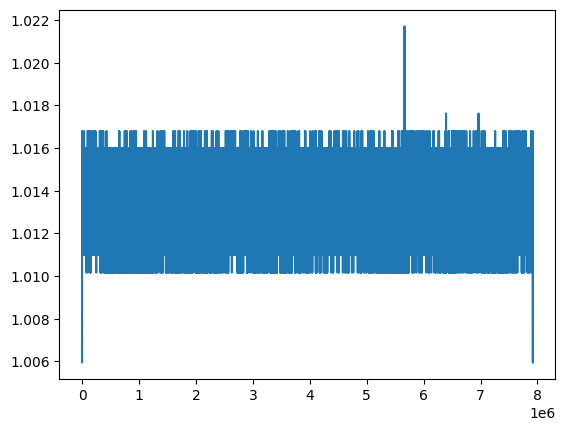

In [16]:
plt.plot(loadFeature_v2(0.5,'COG001','C3','petrosian','beta1',200,cognipath+'/features'))

In [17]:
signalsMetadata[signalsMetadata.subjectId.isin(["COG001"])]


,filename,subjectId,channel,duration,samplerate,isOriginalSamplerate,database
0,COG001_F3.pkl,COG001,F3,39600.0,200,False,COGNITION_v2
1,COG001_C3.pkl,COG001,C3,39600.0,200,False,COGNITION_v2
2,COG001_F4.pkl,COG001,F4,39600.0,200,False,COGNITION_v2
3,COG001_C4.pkl,COG001,C4,39600.0,200,False,COGNITION_v2


## model fitting

In [18]:
def loadFeatureMatrix_v2(subjectList,featureSelection,signalsMetadata,samplerate,datapath):
    featureSelection=featureSelection.reset_index(drop=True)
    
    # operate on the signal lengths of the subjects selected
    thisSignals=signalsMetadata[signalsMetadata.subjectId.isin(subjectList)].copy()
    thisSignals['excerptDimension']=thisSignals.apply(
        lambda row: int(row.duration*samplerate),
        axis=1)
    # initialise the feature matrix
    featureMatrix=np.zeros((np.sum(thisSignals.excerptDimension),len(featureSelection)))
    # fill the matrix
    for i,feature in featureSelection.iterrows():   #iterate the featrures
        characteristic=feature['characteristic']
        bandName=feature['bandName']
        window=feature['window']
        featureValue=np.zeros_like(featureMatrix[:,i])  #initialise a row
        auxStartInd=0
        for j, row in thisSignals.iterrows():   #iterate the signals selected to fill the row
            subject=row['subjectId']
            channel=row['channel']
            excerptDim=row['excerptDimension']
            featurespath=datapath+"/"+row.database+"/features"
            featureValue[auxStartInd:auxStartInd+excerptDim]=loadFeature_v2(str(window),subject,channel,characteristic,bandName,str(samplerate),featurespath)
            auxStartInd=auxStartInd+excerptDim
        featureMatrix[:,i]=featureValue #   fill a row
    return featureMatrix

In [19]:
def loadLabelsVector_v2(subjectList,annotations,signalsMetadata,samplerate):
    #WARNING: annotations must be filtered or union criterium will be used
    # operate on the signal lengths of the subjects selected
    thisSignals=signalsMetadata[signalsMetadata.subjectId.isin(subjectList)].copy()
    thisSignals['excerptDimension']=thisSignals.apply(
        lambda row: int(row.duration*samplerate),
        axis=1)
    # initialise vector of labels
    labelsVector=np.zeros((np.sum(thisSignals['excerptDimension']),))
    auxStartInd=0
    # iterate the signals
    for j, row in thisSignals.iterrows():   #iterate the signals selected to fill the row
        subject=row['subjectId']
        channel=row['channel']
        excerptDim=row['excerptDimension']
        thisAnnotations=annotations[(annotations.subjectId==subject)&(annotations.channel==channel)] #filter the annotations
        labelsVector[auxStartInd:auxStartInd+excerptDim]=excerptAnnotationsToLabels(thisAnnotations,excerptDim) # process all annotations of a given subject
        auxStartInd=auxStartInd+excerptDim
    return labelsVector

In [20]:
n_jobs=4 # paralelization parameter for xgboost (keep it 8 as maximum)
learning_rate=0.4
subsample=0.6

num_boost_round=60  #number of boosting rounds per model

models=[]
modelIds=[]
valF1s=[]
spindleTimeRates=[]
for index, row in experimentModels.iterrows():
    print('**********************')
    print(str(index+1)+' of '+str(len(experimentModels)))
    #Define annotations criterium
    #usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Features
    trainFeatures=loadFeatureMatrix_v2(row.train,featureSelection,signalsMetadata,samplerate,datapath)
    #Labels
    trainLabels=loadLabelsVector_v2(row.train,annotations,signalsMetadata,samplerate)

    break
    #Train the models
    params={
        'n_jobs':n_jobs,
        'learning_rate':learning_rate,
        'subsample':subsample,
        'objective':'binary:logistic'
    }
    trainDMatrix=xgb.DMatrix(data=trainFeatures,label=trainLabels)
    xgb_model = xgb.train(params,trainDMatrix,num_boost_round=num_boost_round)
    spindleTimeRates.append(sum(trainLabels)/len(trainLabels))
    models.append(xgb_model)
    modelIds.append(str(uuid.uuid4()))


**********************
1 of 9


In [21]:
trainFeatures.shape

(190080000, 26)

In [22]:
np.sum(np.isnan(trainFeatures.flatten()))

1448

In [23]:
experimentModels["modelId"]=modelIds
experimentModels["spindleTimeRate"]=spindleTimeRates

ValueError: Length of values (0) does not match length of index (9)

In [ ]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,9e8c92c9-d012-4e46-a60f-74540df5103d,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,16258fa7-20b7-495e-a32f-75aec610ef66,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,3654a0cd-77b5-4bcf-8238-54296d7c1a27,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,8cec6075-9679-4f7b-b5c7-d6ff36147e79,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,5401bdbe-22c1-42a0-9740-d2921a271387,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,2d237bf5-9265-439a-827b-f1411cb4fc3a,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,8bf430c8-bbc9-4ee2-927e-75f7a5e76570,0.006822


## save results

In [ ]:
#create parent folder
experimentpath=datapath+"/experiments/"+experimentId
os.mkdir(experimentpath)
#save each of the models
for id, model in zip(modelIds,models):
    model.save_model(experimentpath+"/"+id+".json")
#save experiment information
dumpPickle(experimentpath+"/experimentModels.pkl",experimentModels)
dumpPickle(experimentpath+"/featureSelection.pkl",featureSelection)

In [ ]:
#you need to use this in the following parts of the experiment
print(experimentId)

09aa67d8-c865-4a95-a7c5-de7b6adadbce
